<a href="https://colab.research.google.com/github/FlaviaFerranti7/CFN_Jigsaw_problem/blob/master/Jigsaw_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#get from imagenet
from bs4 import BeautifulSoup
import requests
import cv2
import PIL
from PIL import Image
import urllib

#read from directory and manipulate
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import itertools
from scipy.spatial.distance import cdist

#model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import optimizers  

from google.colab import drive

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

AUTOTUNE = tf.data.experimental.AUTOTUNE

Found GPU at: /device:GPU:0


In [ ]:
drive.mount('/content/drive', force_remount=True)
imagedir_path = '/content/drive/My Drive/NN/dataset/'

Mounted at /content/drive


#Loading images

In [ ]:
page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n11669921")#flower synset
print(page.content)

b"http://static.flickr.com/224/472279817_0a2a1f6088.jpg\r\nhttp://static.flickr.com/210/500863916_bdd4b8cc5a.jpg\r\nhttp://static.flickr.com/166/367743528_78479af738.jpg\r\nhttp://www.twt.edu.cn/blog/user/w/wutongyeyu1984/Annex/1163777764SPlihZ.JPG\r\nhttp://static.flickr.com/1332/744446616_4a43b88832.jpg\r\nhttp://static.flickr.com/197/502027343_a16a4efbff.jpg\r\nhttp://www.99191.com/WebResources/UploadSoftPic/200801/20080115143103640.jpg\r\nhttp://www.indiana.edu/~nehrigr/yellowstone/flower_8110.jpg\r\nhttp://www.ericandleandra.com/photos/florida303/3_15/images/pitcher_flower.jpg\r\nhttp://fireflyforest.net/images/firefly/2007/March/Pedilanthus-macrocarpus-2.jpg\r\nhttp://www.skyflorist.cn/wp-content/uploads/2008/05/20066151842121061.jpg\r\nhttp://static.flickr.com/1004/912134024_1f19568fd0.jpg\r\nhttp://lh6.ggpht.com/_oVYyQcIgdkA/SDKFB3N8cWI/AAAAAAAAAOc/ejxnG4sHfXc/DPP_0088.JPG\r\nhttp://www.tropicanursery.com/adenium/cultivars/dragon1.jpg\r\nhttp://static.flickr.com/74/181391654_cf

In [ ]:
soup = BeautifulSoup(page.content, 'html.parser')#puts the content of the website into the soup variable, each url on a different line

In [ ]:
animal_page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n01861778")#animal synset
print(animal_page.content)
animal_soup = BeautifulSoup(animal_page.content, 'html.parser')

b'http://farm3.static.flickr.com/2251/1662509436_5d982eaeea.jpg\r\nhttp://lh3.google.com/_k-IQiKQGd2g/Rpmcuv3aT6I/AAAAAAAAAVc/SVwnkTAb55o/s800/IMG_6725.jpg\r\nhttp://newsimg.bbc.co.uk/media/images/42349000/jpg/_42349083_flyingmammal.jpg\r\nhttp://farm3.static.flickr.com/2248/1717020863_149a261403.jpg\r\nhttp://fhtms.sbschools.net/users/bwight/2003/Chelsi1/Mammal2.jpg\r\nhttp://www.planetpuna.com/ThreeDolphins.jpg\r\nhttp://farm1.static.flickr.com/223/482301417_4100a2d3d8.jpg\r\nhttp://lh3.google.com/_omKrRJ15HVc/Rtbb4lBqEkI/AAAAAAAAADE/8O97gzGpQZQ/s800/IMG_1148.jpg\r\nhttp://static.flickr.com/254/450332206_2811fe9c2b.jpg\r\nhttp://static.flickr.com/1250/1487336553_f99ee15b0a.jpg\r\nhttp://farm3.static.flickr.com/2407/2092998073_33beab173f.jpg\r\nhttp://www.qmw.ac.uk/~ugbt991/nmr1.gif\r\nhttp://farm2.static.flickr.com/1420/875911493_de21b2ef31.jpg\r\nhttp://www.deathandhell.com/images/mammal.jpg\r\nhttp://www.sdnhm.org/mammalatlas/images/grasshoppermouse_175w.jpg\r\nhttp://farm1.static.

In [ ]:
str_soup=str(soup)#convert soup to string so it can be split
type(str_soup)
split_urls=str_soup.split('\r\n')#split so each url is a different possition on a list
print(len(split_urls))#print the length of the list so you know how many urls you have

1925


In [ ]:
animal_str_soup=str(animal_soup)#convert soup to string so it can be split
type(animal_str_soup)
animal_split_urls=animal_str_soup.split('\r\n')#split so each url is a different possition on a list
print(len(animal_split_urls))

1329


In [ ]:
def url_to_image(url):
 # download the image, convert it to a NumPy array, and then read
 # it into OpenCV format
 resp = urllib.request.urlopen(url)
 image = np.asarray(bytearray(resp.read()), dtype="uint8")
 image = cv2.imdecode(image, cv2.IMREAD_COLOR)
 
 # return the image
 return image

In [ ]:
def aspect_ratio_resize_smart(img,base=256): #img is a PIL image variable
    color_coverted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                       #PIL Image
    img=Image.fromarray(color_coverted)
    if img.size[0] <= img.size[1]:
        basewidth = base
        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize),PIL.Image.LANCZOS)
    else:
        baseheight = base
        wpercent = (baseheight/float(img.size[1]))
        wsize = int((float(img.size[0])*float(wpercent)))
        img = img.resize((wsize,baseheight),PIL.Image.LANCZOS)
    numpy_image=np.array(img)                                                   #cv2 image
    opencv_image=cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
    return opencv_image

In [ ]:
n_of_training_images=200 #the number of training images to use
for progress in range(n_of_training_images):#store all the images on a directory
    # Print out progress whenever progress is a multiple of 20 so we can follow the
    # (relatively slow) progress
    if(progress%20==0):
        print(progress)
    if not split_urls[progress] == None:
      try:
        I = url_to_image(split_urls[progress])
        if (len(I.shape))==3: #check if the image has width, length and channels
          I = aspect_ratio_resize_smart(I,base=256)
          save_path = '/content/drive/My Drive/NN/dataset/train/flower/img'+str(progress)+'.jpg'                             #save on drive
          cv2.imwrite(save_path,I)
      except:
        None

0
20
40
60
80
100
120
140
160
180


In [ ]:
#do the same for animal:
for progress in range(n_of_training_images):#store all the images on a directory
    # Print out progress whenever progress is a multiple of 20 so we can follow the
    # (relatively slow) progress
    if(progress%20==0):
        print(progress)
    if not animal_split_urls[progress] == None:
      try:
        I = url_to_image(animal_split_urls[progress])
        if (len(I.shape))==3: #check if the image has width, length and channels
          I = aspect_ratio_resize_smart(I, base=256)
          save_path = '/content/drive/My Drive/NN/dataset/train/animal/img'+str(progress)+'.jpg'
          cv2.imwrite(save_path,I)
      except:
        None

0
20
40
60
80
100
120
140
160
180


#Utils

In [ ]:
def hamming_set(num_crops, num_permutations, selection):
    """
    generate and save the hamming set
    :param num_crops: number of tiles from each image
    :param num_permutations: Number of permutations to select (i.e. number of classes for the pretext task)
    :param selection: Sample selected per iteration based on hamming distance: [max] highest; [mean] average
    :param output_file_name: name of the output HDF5 file
    """
    P_hat = np.array(list(itertools.permutations(list(range(num_crops)), num_crops)))
    n = P_hat.shape[0]

    for i in range(num_permutations):
        if i == 0:
            j = np.random.randint(n)
            P = np.array(P_hat[j]).reshape([1, -1])
        else:
            P = np.concatenate([P, P_hat[j].reshape([1, -1])], axis=0)
        P_hat = np.delete(P_hat, j, axis=0)
        D = cdist(P, P_hat, metric='hamming').mean(axis=0).flatten()
        if selection == 'max':
            j = D.argmax()
        elif selection == 'min':
            j = D.argmin()
        elif selection == 'mean':
            m = int(D.shape[0] / 2)
            S = D.argsort()
            j = S[np.random.randint(m - 10, m + 10)]
    return P


P = hamming_set(num_crops=9, num_permutations=10, selection='mean')
print(P)

[[3 0 5 8 1 2 4 6 7]
 [0 1 2 3 4 5 6 7 8]
 [1 2 0 4 3 6 7 8 5]
 [2 3 1 0 5 7 8 4 6]
 [4 5 3 6 7 8 0 1 2]
 [5 4 6 7 8 0 1 2 3]
 [6 7 8 1 0 3 2 5 4]
 [7 8 4 2 6 1 5 3 0]
 [8 6 7 5 2 4 3 0 1]
 [0 1 2 3 6 4 8 5 7]]


In [ ]:
images_path_flower = [os.path.join(imagedir_path+'train/flower', x) for x in os.listdir(imagedir_path+'train/flower')]
images_path_animal = [os.path.join(imagedir_path+'train/animal', x) for x in os.listdir(imagedir_path+'train/animal')]
images_path = images_path_flower + images_path_animal 

In [ ]:
print(len(images_path))

210


In [ ]:
def path_to_array(path):
    img = load_img(path)
    img = img_to_array(img)
    img /= 255.                               #normalizing image
    return img

/content/drive/My Drive/NN/dataset/train/flower/img112.jpg
flower


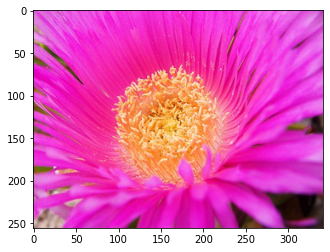

In [ ]:
print(images_path[55])
path=os.path.dirname(images_path[55])
label = os.path.basename(path)
print(label)
img1 = path_to_array(images_path[55])
plt.imshow(img1)

In [ ]:
def gray(img):
  r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
  grayscale_image = 0.2989 * r + 0.5870 * g + 0.1140 * b
  grayscale_image = np.stack((grayscale_image,)*3, axis=-1) #expand dimension to have (h,w,3)
  return grayscale_image

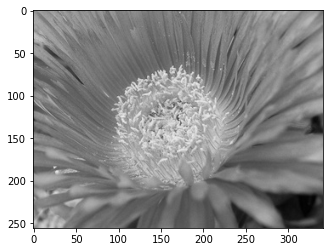

In [ ]:
plt.imshow(gray(img1), cmap=plt.get_cmap("gray"))

In [ ]:
def colour_channel_jitter(numpy_image, colourJitter=2):
        # Determine the dimensions of the array, minus the crop around the border
        # of 4 pixels (threshold margin due to 2 pixel jitter)
        x_dim = numpy_image.shape[0] - colourJitter * 2
        y_dim = numpy_image.shape[1] - colourJitter * 2
        # Determine the jitters
        R_xjit = randint(0,colourJitter * 2 + 1)
        R_yjit = randint(0,colourJitter * 2 + 1)
        # Seperate the colour channels
        return_array = np.empty((x_dim, y_dim, 3), np.float32)
        for colour_channel in range(3):
            return_array[:,:,colour_channel] = numpy_image[R_xjit:x_dim +
                                            R_xjit, R_yjit:y_dim + R_yjit, colour_channel]
        return return_array

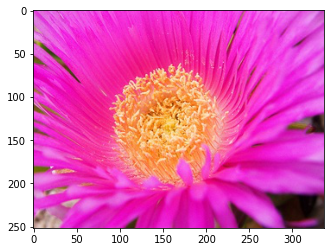

In [ ]:
img1 = colour_channel_jitter(img1)
plt.imshow(img1)

In [ ]:
def square_image(img, sub_size=225):
  max_offset = 252 - sub_size

  y_offset = randint(0, max_offset)
  x_offset = randint(0, max_offset)
  sub = img[y_offset:y_offset+sub_size, x_offset:x_offset+sub_size, :]
  return sub

(225, 225, 3)


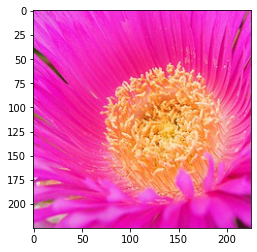

In [ ]:
img1 = square_image(img1)
plt.imshow(img1)
print(img1.shape)

In [ ]:
def create_ordered_tiles(img, cellSize=75, tileSize=64):
  tile_offset = cellSize - tileSize 
  tiles = np.zeros((tileSize, tileSize, 3, 9), dtype=np.float32)
  for row in range(3):
    for col in range(3):
      x_start = col * cellSize + randint(0,tile_offset)
      y_start = row * cellSize + randint(0,tile_offset)
      tiles[:, :, :, row * 3 + col]= img[y_start:y_start + tileSize, x_start:x_start + tileSize, :]
  return tiles

In [ ]:
def normalize_tiles(tiles):
  for i in range(9):
    pixels = tiles[:, :, :, i]
    pixels = pixels.astype('float32')
    mean, std = pixels.mean(axis=(0,1), dtype='float64'), pixels.std(axis=(0,1), dtype='float64')
    pixels = (pixels - mean) / std
    tiles[:, :, :, i] = pixels
  return tiles

In [ ]:
def create_tiles(img, tileSize=64):
  tiles=create_ordered_tiles(img)
  perm_index = randint(0,len(P))
  final_crops = np.zeros((tileSize, tileSize, 3, 9), dtype=np.float32)
  for i in range(9):
    final_crops[:, :, :, P[perm_index, i]] = tiles[:,:,:,i]
  return final_crops, perm_index

(64, 64, 3, 9)
2


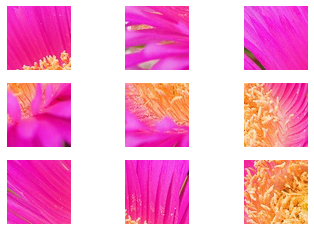

In [ ]:
tiles, perm_index = create_tiles(img1)
print(tiles.shape)
print(perm_index)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(tiles[:,:,:,i])
  plt.axis("off")

#Creating dataset

In [ ]:
batch_size = 16

In [ ]:
def structure_dataset(batch_index, images_path=images_path, batch_size=32, tile_size=64, channels=3, n_crops=9,jitter=2):
  batch_x = images_path[batch_index * batch_size:(batch_index + 1) * batch_size] #batch_size images at time
  labels = np.empty(batch_size)                                                 # label for each image: (32,10)
  images = [np.empty((batch_size, tile_size, tile_size, channels), np.float32) for _ in range(n_crops)]  # 9 array with (32,64,64,3); one for each alexnet
  for image_num in range(batch_size):
    img = path_to_array(batch_x[image_num])
    #if np.random.uniform() < 0.3:
      #jitter = 0
      #img = gray(img)
    img = colour_channel_jitter(img,jitter)
    img = square_image(img)
    # Transform the image into its nine croppings
    single_image, labels[image_num] = create_tiles(img)
    single_image = normalize_tiles(single_image)                                #normalizing tiles
    for image_tile in range(n_crops):
      images[image_tile][image_num, :, :, :] = single_image[:, :, :, image_tile]
  return images, labels

In [ ]:
def one_hot_label(labels):
  return np.array([[1 if labels[i] == j else 0 for j in range(len(P))]
                         for i in range(labels.shape[0])])

In [ ]:
def create_dataset(images_path=images_path, batch_size=32):
  numBatches = len(images_path) // batch_size
  batch_index = 0
  while True:
    images, labels = structure_dataset(batch_index, images_path, batch_size)
    batch_index += 1  # Increment the batch index
    if batch_index == numBatches:
      batch_index = 0
    yield images, one_hot_label(labels)

Creating training and validation set

In [ ]:
train, valid = train_test_split(images_path, test_size = 0.2)
training_cfn_dataset = create_dataset(train, batch_size)
validation_cfn_dataset = create_dataset(valid, batch_size)

# CFN Model

In [ ]:
alex_net = models.Sequential()
#first layer
conv1 = Conv2D(96, (11, 11), activation='relu', strides=(2, 2), padding='same', name='CONV1', input_shape=(64, 64, 3))
alex_net.add(conv1)
maxpool1 = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='MaxPool1')
alex_net.add(maxpool1)

#second layer
conv2 = Conv2D(256, (5, 5), strides=(2, 2), activation='relu', padding='valid', name='CONV2')
alex_net.add(conv2)
maxpool2 = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='MaxPool2')
alex_net.add(maxpool2)

#third layer
conv3 = Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same', name='CONV3')
alex_net.add(conv3)

#fourth layer
conv4 = Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same', name='CONV4')
alex_net.add(conv4)

#fifth layer
conv5=Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='CONV5')
alex_net.add(conv5)
maxpool3 = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='MaxPool3')
alex_net.add(maxpool3)

flatten = Flatten()
alex_net.add(flatten)
fc6=Dense(512, activation='relu', name='FC6')
alex_net.add(fc6)
alexdropout= Dropout(0.5, name='dropout_alexnet')
alex_net.add(alexdropout)


In [ ]:
def CFN(model, tilesize=64, permutations=10):
	inputs = [Input((tilesize, tilesize, 3)) for x in range(9)]
	tower_outputs = [model(input) for input in inputs]
	x = Concatenate()(tower_outputs)
	x = Dense(4096, name='FC7')(x)
	x = Activation("relu")(x)
	x = Dropout(0.5, name='last_dropout')(x)
	x = Dense(permutations, name='FC8')(x)
	predictions =  Activation("softmax")(x)
	cfn = Model(inputs, predictions, name="CFN")
	return cfn

In [ ]:
model_cfn = CFN(alex_net)
optimizer = optimizers.Adam(lr=0.00001)   #optimizers.SGD(learning_rate=0.01)
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
model_cfn.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
history = model_cfn.fit_generator(training_cfn_dataset,
                              epochs=80,
                              callbacks=[stopping],
                              steps_per_epoch=(len(images_path)*0.8) // batch_size,
                              validation_data=validation_cfn_dataset,
                              validation_steps=(len(images_path)*0.2) // batch_size)


Epoch 1/80
84/84 [==============================] - 3s 37ms/step - loss: 2.2632 - accuracy: 0.1607 - val_loss: 2.1955 - val_accuracy: 0.3095
Epoch 2/80
84/84 [==============================] - 3s 37ms/step - loss: 2.2266 - accuracy: 0.2321 - val_loss: 2.2578 - val_accuracy: 0.1905
Epoch 3/80
84/84 [==============================] - 3s 37ms/step - loss: 2.2121 - accuracy: 0.2262 - val_loss: 2.1003 - val_accuracy: 0.3571
Epoch 4/80
84/84 [==============================] - 3s 36ms/step - loss: 2.2300 - accuracy: 0.2083 - val_loss: 2.1919 - val_accuracy: 0.2619
Epoch 5/80
84/84 [==============================] - 3s 37ms/step - loss: 2.2109 - accuracy: 0.2381 - val_loss: 2.2267 - val_accuracy: 0.2381
Epoch 6/80
84/84 [==============================] - 3s 37ms/step - loss: 2.1962 - accuracy: 0.2798 - val_loss: 2.1509 - val_accuracy: 0.3095
Epoch 7/80
84/84 [==============================] - 3s 37ms/step - loss: 2.1838 - accuracy: 0.2857 - val_loss: 2.1956 - val_accuracy: 0.2857
Epoch 8/80
84

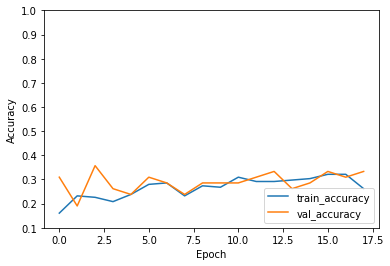

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

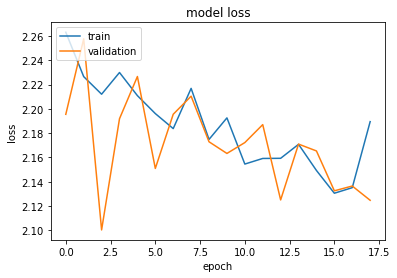

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_steps = np.ceil((len(images_path)*0.2) // batch_size)
test_loss, test_acc = model_cfn.evaluate(validation_cfn_dataset, verbose=1, steps=test_steps)
print(test_acc)

21/21 [==============================] - 0s 13ms/step - loss: 2.1874 - accuracy: 0.2619
0.261904776096344


# Classification task

##Labeled Dataset

In [ ]:
list_ds = tf.data.Dataset.list_files(images_path, shuffle=False)
list_ds = list_ds.shuffle(len(images_path), reshuffle_each_iteration=False)
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/My Drive/NN/dataset/train/animal/img37.jpg'
b'/content/drive/My Drive/NN/dataset/train/animal/img195.jpg'
b'/content/drive/My Drive/NN/dataset/train/animal/img51.jpg'
b'/content/drive/My Drive/NN/dataset/train/flower/img105.jpg'
b'/content/drive/My Drive/NN/dataset/train/animal/img35.jpg'


In [ ]:
directory = np.array([ os.path.basename(os.path.dirname(item)) for item in images_path ])
CLASS_NAMES = []
for elem in directory:
  if elem not in CLASS_NAMES:
    CLASS_NAMES.append(elem)

CLASS_NAMES

['flower', 'animal']

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.sep)
  return parts[-2] == CLASS_NAMES

In [ ]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 328, 3)
Label:  [False  True]


In [ ]:
def is_test(x, y):
    return x % 5 == 0

def is_train(x, y):
    return not is_test(x, y)

recover = lambda x,y: y

validation_ds = labeled_ds.enumerate() \
                    .filter(is_test) \
                    .map(recover)

training_ds = labeled_ds.enumerate() \
                    .filter(is_train) \
                    .map(recover)

In [ ]:
def crop_training(img, label):
  img = tf.image.random_crop(img, size=[224, 224, 3]) 
  return img, label

In [ ]:
def crop_validation(img, label):
  img = tf.image.resize_with_crop_or_pad(img,224,224)
  return img, label

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=10, training=True):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  if training == True:
    ds = ds.map(crop_training, num_parallel_calls=AUTOTUNE)
  else:
    ds = ds.map(crop_validation, num_parallel_calls=AUTOTUNE)

  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)

  ds = ds.repeat()
  ds = ds.batch(batch_size)

  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
training_dataset = prepare_for_training(training_ds)
validation_dataset = prepare_for_training(validation_ds, training=False)

In [ ]:
input_shape = (224,224,3)
input_shape

(224, 224, 3)

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(15):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[list(label_batch[n]).index(True)])
      plt.axis('off')

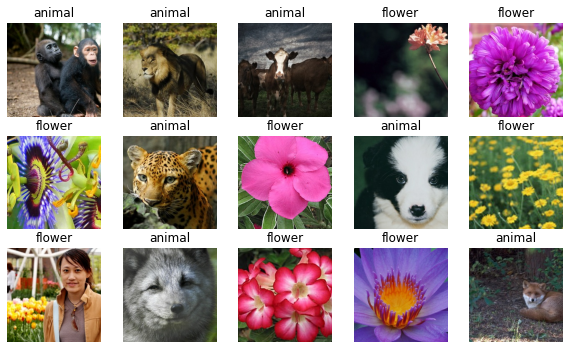

In [ ]:
image_batch, label_batch = next(iter(training_dataset))
show_batch(image_batch.numpy(), label_batch.numpy())

## Transfer learning on standard Alexnet

In [ ]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=input_shape, activation='relu', kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu', strides=(2,2), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', name='CONV5'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(BatchNormalization())
AlexNet.add(Dropout(0.5))

#Output Layer
AlexNet.add(Dense(len(CLASS_NAMES), activation='softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 96)      34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 384)      

In [ ]:
trainable_layers = ["CONV5"]
index = 1000
for idx, layer in enumerate(AlexNet.layers):
  if layer.name == "CONV5":
    index = idx
  if idx > index:
    trainable_layers.append(layer.name)
  if idx==1 or idx==4:
    trainable_layers.append(layer.name)

In [ ]:
print(trainable_layers)

['CONV5', 'batch_normalization', 'batch_normalization_1', 'batch_normalization_2', 'max_pooling2d_2', 'flatten_3', 'dense', 'batch_normalization_3', 'dropout', 'dense_1']


In [ ]:
firstconv = [
  np.array(conv1.get_weights()[0]),
  np.array(conv1.get_weights()[1])
]
secondconv = [
  np.array(conv2.get_weights()[0]),
  np.array(conv2.get_weights()[1])
]
thirdconv = [
  np.array(conv3.get_weights()[0]),
  np.array(conv3.get_weights()[1])
]
fourthconv = [
  np.array(conv4.get_weights()[0]),
  np.array(conv4.get_weights()[1])
]
fifthconv = [
  np.array(conv5.get_weights()[0]),
  np.array(conv5.get_weights()[1])
]


In [ ]:
AlexNet.layers[0].set_weights(firstconv)
AlexNet.layers[3].set_weights(secondconv)
AlexNet.layers[6].set_weights(thirdconv)
AlexNet.layers[7].set_weights(fourthconv)
AlexNet.layers[8].set_weights(fifthconv)

In [ ]:
for idx,layer in enumerate(AlexNet.layers):
  if layer.name in trainable_layers:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
optimizer = optimizers.Adam(lr=0.00001)
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
AlexNet.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
history = AlexNet.fit_generator(training_dataset,
                              epochs=80,
                              callbacks=[stopping],
                              steps_per_epoch=(len(images_path)*0.8) // batch_size,
                              validation_data=validation_dataset,
                              validation_steps=(len(images_path)*0.2) // batch_size)

Epoch 1/80
84/84 [==============================] - 3s 31ms/step - loss: 0.6227 - accuracy: 0.6667 - val_loss: 0.4913 - val_accuracy: 0.8095
Epoch 2/80
84/84 [==============================] - 2s 22ms/step - loss: 0.6112 - accuracy: 0.6905 - val_loss: 0.4486 - val_accuracy: 0.8810
Epoch 3/80
84/84 [==============================] - 2s 21ms/step - loss: 0.6182 - accuracy: 0.6845 - val_loss: 0.5126 - val_accuracy: 0.7857
Epoch 4/80
84/84 [==============================] - 2s 21ms/step - loss: 0.6554 - accuracy: 0.6369 - val_loss: 0.5287 - val_accuracy: 0.7619
Epoch 5/80
84/84 [==============================] - 2s 21ms/step - loss: 0.5756 - accuracy: 0.7202 - val_loss: 0.5020 - val_accuracy: 0.8095
Epoch 6/80
84/84 [==============================] - 2s 21ms/step - loss: 0.6548 - accuracy: 0.6250 - val_loss: 0.5000 - val_accuracy: 0.7857
Epoch 7/80
84/84 [==============================] - 2s 21ms/step - loss: 0.5870 - accuracy: 0.7083 - val_loss: 0.5423 - val_accuracy: 0.7381
Epoch 8/80
84

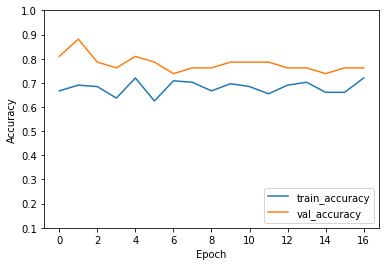

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

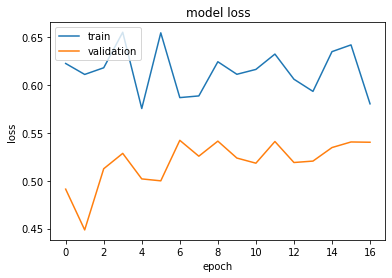

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_steps = np.ceil((len(images_path)*0.2) // batch_size)
test_loss, test_acc = AlexNet.evaluate(validation_dataset, verbose=1, steps=test_steps)
print(test_acc)

21/21 [==============================] - 0s 6ms/step - loss: 0.4486 - accuracy: 0.8810
0.8809523582458496
